In [1]:
from bprg.config import default_graph
# from bprg.plotting import PercolationViz
from bprg.simulation import BPRG

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

KWARGS = {'prog': 'twopi', 'root': 0}
EDGE_OPTIONS = {
    'width': 0.1,
    'alpha': 0.6,
}
NODE_OPTIONS = {
    'node_size': 17,
    'alpha':0.9,    
}
FIGSIZE = (6, 6)

class PercolationViz():
    def __init__(self, A, kv_list, **kwargs):
        if not kwargs: kwargs = KWARGS
        self.A = A
        self.nv = A.shape[0]
        # threshold vectors through iterations
        self.kv_list = kv_list
        # get K
        K = len(np.unique(kv_list))-1
        self.K = K
        # generate edge list
        edges = self.adjacency_to_edges()
        self.edges = edges
        # index by group through iterations
        self.ikv_list = [
            self.index_by_group(kv, range(K+1))
            for kv in kv_list]
        # edge type by group through interations
        self.iedge_list = [
            self.check_infectious_edge(edges, ikv)
            for ikv in self.ikv_list]
        # generate networkx 
        G = nx.Graph()
        G.add_edges_from(self.edges)
        self.G = G
        self.pos = nx.nx_agraph.graphviz_layout(
            self.G, **kwargs)
        
        
        init_ikv = {0: [], 1: [], 2: list(range(self.nv))}
        init_iedge = {0: [], 1: [], 2: self.edges}
        self.ikv_list = [init_ikv] + self.ikv_list
        self.iedge_list = [init_iedge] + self.iedge_list
    
    def adjacency_to_edges(self):
        edges = [(i,j) for i in range(self.nv)
                 for j in range(self.nv)
                 if self.A[i,j]==1 and i!=j]
        return edges

    def index_by_group(self, kv, k_list):
        return {k: np.where(kv==k)[0].tolist()
                    for k in k_list}
    
    
    def check_infectious_edge(self, edges, ikv):
        edge_dict = {0: [], 1:[], 2:[]}
        for edge in edges:
            if (edge[0] in ikv[0]) and (edge[1] in ikv[0]):
                edge_dict[0].append(edge)
            elif (edge[0] in ikv[0]) and (edge[1] not in ikv[0]):
                edge_dict[1].append(edge)
            else:
                edge_dict[2].append(edge)
        return edge_dict


    def plot_network_infection(self, G, pos, ikv, iedge,
                               figsize=FIGSIZE,  ax=None,
                               node_options=NODE_OPTIONS,
                               edge_options=EDGE_OPTIONS):
        node_color_list = ['violet', 'turquoise', 'springgreen']
        edge_color_list = ['violet', 'violet', 'springgreen']


        for k in range(self.K + 1):
            nodelist = [i for i in ikv[k] if i in pos.keys()]
            nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=nodelist,
                                   node_color=node_color_list[k],
                                   **node_options)

            edgelist = iedge[k]
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edgelist,
                                  edge_color=edge_color_list[k],
                                  **edge_options)
        plt.tight_layout()
        plt.axis("off")
    
    def get_percolation_plots(self, figsize=FIGSIZE,
                              node_options=NODE_OPTIONS,
                              edge_options=EDGE_OPTIONS):
        G = self.G
        pos = self.pos
        ikv_list = self.ikv_list
        iedge_list = self.iedge_list

        figs = []
        
        for i in range(len(self.kv_list)):
            ikv = ikv_list[i]
            iedge = iedge_list[i]
            fig = plt.figure(figsize=figsize)
            self.plot_network_infection(
                G, pos, ikv, iedge, figsize, ax=None,
                node_options=node_options, edge_options=edge_options)
            figs.append(fig)            
        return figs
    
    def get_percolation_plot(self, nrows, ncols, idx_list,
                             figsize=(12,8), subfigsize=FIGSIZE,
                             node_options=NODE_OPTIONS,
                             edge_options=EDGE_OPTIONS
                             ):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        for i, ax in zip(idx_list, np.ravel(axes)):
            self.plot_network_infection(
                self.G, self.pos, self.ikv_list[i], self.iedge_list[i],
                figsize=subfigsize, ax=ax,
                node_options=node_options,
                edge_options=edge_options)
            ax.axis("off")
        return fig

In [3]:
locals().update(default_graph)
default_graph

{'ns': 1000,
 'dx': 0.001,
 'S': [0, 1],
 'K': 2,
 'η': array([0.1, 0. , 0.9]),
 'μ': <function bprg.config.<lambda>(x)>,
 'κ': <function bprg.config.<lambda>(x, y)>}

In [4]:
L = 100
nv = 100
bprg = BPRG(nv, S, L, K, κ, η)
# seed = 4569
np.random.seed(2021)
sim = bprg.simulate()

A = sim['A']
kv_list = sim['kv_list']
len(kv_list)

2021-12-08 00:11:15.216846: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9

In [11]:
EDGE_OPTIONS = {
    'width': 0.25,
    'alpha': 0.5,
}

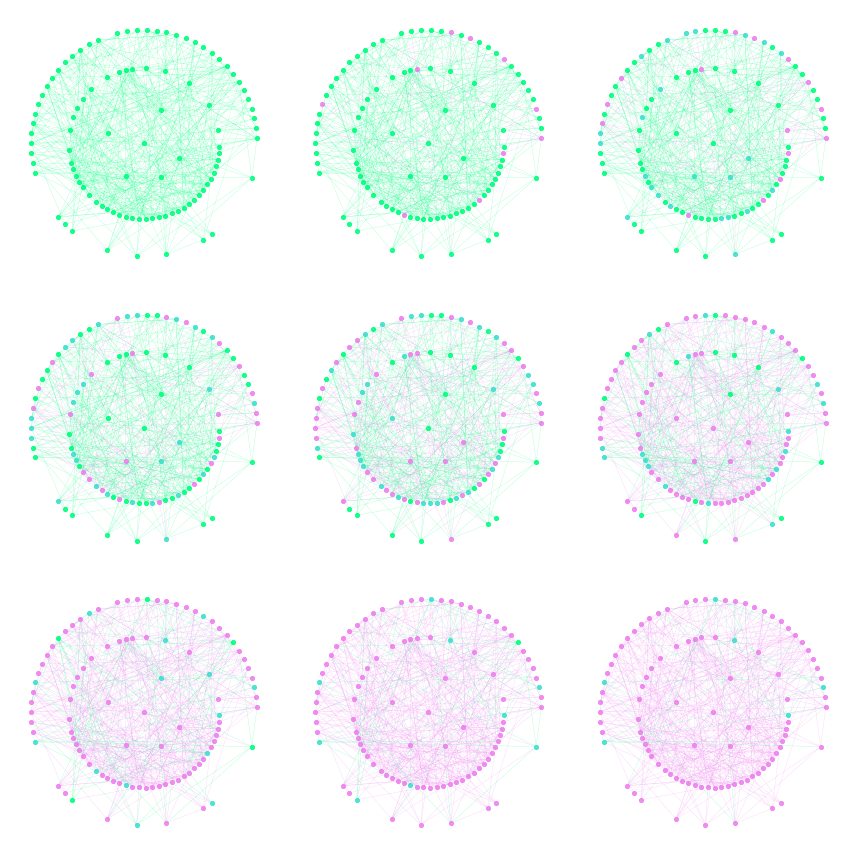

In [12]:
pv = PercolationViz(A, kv_list, prog='twopi', root=1)
fig = pv.get_percolation_plot(3,3,range(9), figsize=(12,12), edge_options=EDGE_OPTIONS)
fig.savefig('../fig/perc_combo_thick.pdf', format='pdf', transparent=True)

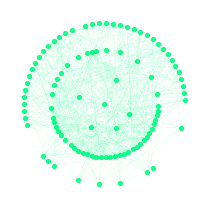

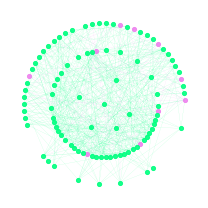

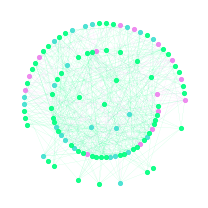

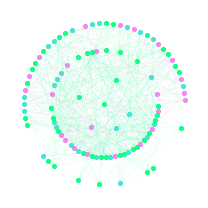

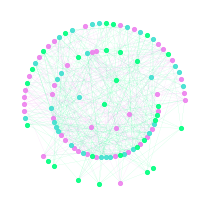

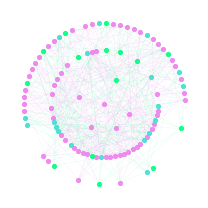

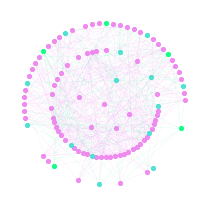

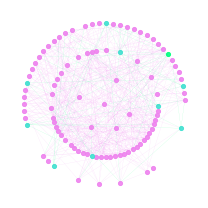

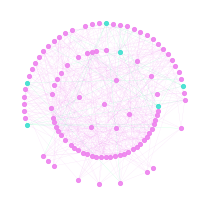

In [46]:
pplots = pv.get_percolation_plots(figsize=(3,3))